NON-SEPARABLE CLASSIFICATION PROJECT – MULTI-FONT CHARACTER RECOGNITION:

Megan Petralia


The following scientific publication was used for reference:

Font Recognition by a Neural Network

Author Ming-Chih Lee , William J.B., Oldham

https://www.sciencedirect.com/science/article/abs/pii/S0020737305801142


Import packages to use such as pandas for dataframe aggregation and manipulation as well matplotlib and seaborn for plotting. Tensorflow, keras for model building. Sklearn and bayes_opt for normalization and optimization.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import io
from bayes_opt import BayesianOptimization
import sklearn
import seaborn as sns
from sklearn.metrics import confusion_matrix

## Importing more required libraries
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
import warnings

#makes numby printouts easier to read
np.set_printoptions(precision=3, suppress=True)

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense

print(tf.__version__)

2.8.0


Known information about data used:

The network will be trained on upper-case English letters in selected fonts. The data that will be used for this project, consisting of 6 fonts (Courier, New York, Chicago, Geneva, Times, and Venice), was collected and quantized by Lee (see reference linked above). A brief summary of the data collection method is presented here:
1. The image of the letter is normalized to an 18 x 18 character matrix, where the line thickness is one and the image is represented by 0's (background) and 1's (foreground).
2. Fourteen properties similar to those proposed by Fujii and Morita were extracted from each image. Each property is a 3 x 3 matrix, thus, for each image, a 14 x 9 matrix is generated. This is the X matrix for that image. A property recognition matrix, Y, is constructed for each image and is also a 14 x 9 matrix. It is chosen arbitrarily and is as simple as possible. W is a 9 x 9 filter matrix which maps X to Y and can be found from: W = X* Y, where X* the pseudo-inverse of X.
3. A 3 x 3 window is moved from upper left to lower right over the character image. The 9 elements in the window are multiplied by the matrix W. If the output matches a row of Y, say row k, the kth place in the count matrix is incremented by the weighting factor of that property.
Thus, the count matrix for a character contains the number of exact template matches, weighted by position. The result is 156 (26 x 6) 14-element vectors.

Alphabet training and testing datasets are imported.

In [4]:
loc_train = ("Alphabet_training.txt")
loc_test = ("Alphabet_testing.txt")

Data is reformatted into input/output train/test arrays

In [5]:
f = open(loc_train, "r")
string = f.read()
array = np.fromstring(string, dtype=int, sep='\n')
split_array = np.array_split(array, 78)
#split_array[1]


Inputs have 14 features

In [6]:

input_array = [item[0:14] for item in split_array]
input_array = np.array(input_array)
input_array[0].shape


(14,)

Look at first 4 inputs

In [8]:
input_array[0:4]

array([[ 8,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  8],
       [ 7,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 11],
       [12, 10,  1,  1,  0,  0,  0,  4,  6,  0,  0,  0,  0,  2],
       [21, 10,  4,  4,  0,  1,  1,  0,  5,  0,  2,  0,  0,  2]])

Outputs have 26 classes, for all 26 letters

In [9]:
output_array = [item[14:] for item in split_array]
output_array = np.array(output_array)
output_array[0].shape

(26,)

Look at first 4 outputs

In [10]:
output_array[0:4]

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0]])

In [11]:
f = open(loc_test, "r")
string = f.read()
array = np.fromstring(string, dtype=int, sep='\n')
split_array = np.array_split(array, 78)
#split_array[1]

In [12]:
input_test_array = [item[0:14] for item in split_array]
input_test_array = np.array(input_array)
#input_test_array[0].shape

In [13]:
output_test_array = [item[14:] for item in split_array]
output_test_array = np.array(output_test_array)
#output_test_array

Normalization/Scaling:
Normalization or scaling is not needed here. This procdure is provided with an even dataset of all different 26 letters in each of 3 fonts. With the letter image input/output , essentially already hot coded, the data is ready to be input into a model.

Next, the Keras Model is defined.

- The keras model defined includes 2 rectified linear functions, 1 drop out to prevent overfitting, and 1 sigmoid layer, respectively.

- The specific layer values (shape , drop out rate , etc.) are decided by the bayesian optimizer below.

In [14]:
# Defining various initialization parameters for MLP model
num_features = input_array.shape[1]
num_classes = output_array.shape[1] 

# Let's create a helper function first which builds the model with various parameters.
def get_model(input_dim, dense_0_neurons, dense_1_neurons, dropout_rate, num_classes):
    # Builds a Sequential MLP model using Keras and returns it
    
    # Define the keras model
    model = Sequential()
    model.add(Dense(dense_0_neurons, input_dim=input_dim, activation='relu', name="dense_1"))
    model.add(Dense(dense_1_neurons, activation='relu', name="dense_2"))
    model.add(Dropout(dropout_rate, name="dropout"))
    model.add(Dense(num_classes, activation='sigmoid', name="dense_3"))
    return model

The model takes 14 input features, and outputs 26 classes

In [15]:
print('# Features: ' , num_features)
print('# Classes: ' , num_classes)

# Features:  14
# Classes:  26


Next, the following functions are set up for the Bayesian Optimizer

- The model is built for optimization using categorical cross entropy as the loss function, stochastic gradient descent for optimization, and accuracy as the performance metric. Batch size is 26, chosen becuase it's approximately 1/3 of the size of the training dataset.

- Because of the nature of the dataset, I decided not to take out part of the training dataset for validation. Cross-fold validation makes less sense, because there are only three records of each letter, of a differe font each, it seems more optimal to focus on accuracy compared to the test dataset and utilize on the training records for training.

In [16]:
#Bayesian Optimizer
def fit_with(num_features, num_classes, verbose, dense_0_neurons_x20, dense_1_neurons_x26, dropout_rate):

    # Calculate true hyperparameter values for discrete variables.
    dense_0_neurons = max(int(dense_0_neurons_x20 * 20), 20)
    dense_1_neurons = max(int(dense_1_neurons_x26 * 26), 26)
  
    # Create the model using a specified hyperparameters.
    model = get_model(num_features, dense_0_neurons, dense_1_neurons, dropout_rate, num_classes)

    # Compile the keras model for a specified number of epochs.
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    # Fit keras model
    history = model.fit(input_array, output_array, 
                        epochs=5, 
                        batch_size=26, #3 batches for 78 length dataset
                        validation_split = 0.00, 
                        verbose=verbose)

    # Evaluate the model with the eval dataset.
    score = model.evaluate(input_array, output_array,
                                  batch_size=26, verbose=0)
    print('Test loss:', score[0], '   Test accuracy:', score[1])

    # Return the accuracy.
    return score[1]

from functools import partial

verbose = 1
fit_with_partial = partial(fit_with, num_features, num_classes, verbose) # Handles fixed parameters during optimization


Bayesian Optimizer is run, with accuracy and loss output at each iteration.

In [17]:
# Bounded region of parameter space
pbounds = {'dense_0_neurons_x20': (0.9, 4.1), 'dense_1_neurons_x26': (0.9, 4.1), 'dropout_rate': (0, 0.3)}

optimizer = BayesianOptimization(
    f=fit_with_partial,
    pbounds=pbounds,
    verbose=1,  # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)

optimizer.maximize(init_points=3, n_iter=5)

for i, res in enumerate(optimizer.res):
    print("Iteration {}: \n\t{}".format(i, res))

print(optimizer.max)

|   iter    |  target   | dense_... | dense_... | dropou... |
-------------------------------------------------------------
Epoch 1/5
3/3 [==============================] - 0s 3ms/step - loss: 4.2215 - accuracy: 0.0128
Epoch 2/5
3/3 [==============================] - 0s 3ms/step - loss: 3.8679 - accuracy: 0.0513
Epoch 3/5
3/3 [==============================] - 0s 2ms/step - loss: 3.5691 - accuracy: 0.0641
Epoch 4/5
3/3 [==============================] - 0s 2ms/step - loss: 3.3302 - accuracy: 0.0641
Epoch 5/5
3/3 [==============================] - 0s 2ms/step - loss: 3.1399 - accuracy: 0.1410
Test loss: 3.014878273010254    Test accuracy: 0.19230769574642181
Epoch 1/5
3/3 [==============================] - 0s 2ms/step - loss: 4.1643 - accuracy: 0.0128
Epoch 2/5
3/3 [==============================] - 0s 4ms/step - loss: 3.8700 - accuracy: 0.0385
Epoch 3/5
3/3 [==============================] - 0s 3ms/step - loss: 3.6658 - accuracy: 0.0641
Epoch 4/5
3/3 [==============================] - 

Learning with Hyper-parameter setting

- With the hyper-parameter tuning, we can see that the accuracy does go up - for training.

In [19]:
# Create the model using a specified hyperparameters.
dense_0_neurons=2.47*20; dense_1_neurons=3.58*26; dropout_rate=0.0 #hyper-parameters found above are used as 3.8 and 3.53
model = get_model(num_features, dense_0_neurons, dense_1_neurons, dropout_rate, num_classes)

# Compile the keras model for a specified number of epochs.
model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fit keras model
history = model.fit(input_array, output_array, epochs=35, batch_size=26, 
                        validation_split = 0.00, verbose=2)

# Evaluate the model with the eval dataset.
score = model.evaluate(input_test_array, output_test_array,
                                  batch_size=26, verbose=0)
print('Test loss:', score[0], '   Test accuracy:', score[1])

Epoch 1/35
3/3 - 0s - loss: 3.6829 - accuracy: 0.0769 - 297ms/epoch - 99ms/step
Epoch 2/35
3/3 - 0s - loss: 3.3143 - accuracy: 0.0897 - 5ms/epoch - 2ms/step
Epoch 3/35
3/3 - 0s - loss: 3.0633 - accuracy: 0.1154 - 6ms/epoch - 2ms/step
Epoch 4/35
3/3 - 0s - loss: 2.8862 - accuracy: 0.1538 - 5ms/epoch - 2ms/step
Epoch 5/35
3/3 - 0s - loss: 2.7351 - accuracy: 0.2564 - 8ms/epoch - 3ms/step
Epoch 6/35
3/3 - 0s - loss: 2.5933 - accuracy: 0.2308 - 5ms/epoch - 2ms/step
Epoch 7/35
3/3 - 0s - loss: 2.4724 - accuracy: 0.2564 - 8ms/epoch - 3ms/step
Epoch 8/35
3/3 - 0s - loss: 2.3499 - accuracy: 0.4103 - 6ms/epoch - 2ms/step
Epoch 9/35
3/3 - 0s - loss: 2.2339 - accuracy: 0.4615 - 7ms/epoch - 2ms/step
Epoch 10/35
3/3 - 0s - loss: 2.1264 - accuracy: 0.4872 - 5ms/epoch - 2ms/step
Epoch 11/35
3/3 - 0s - loss: 2.0287 - accuracy: 0.5513 - 5ms/epoch - 2ms/step
Epoch 12/35
3/3 - 0s - loss: 1.9278 - accuracy: 0.6282 - 4ms/epoch - 1ms/step
Epoch 13/35
3/3 - 0s - loss: 1.8400 - accuracy: 0.6667 - 5ms/epoch - 2

- Looking at the output, we can see that the model creates an approximate 94% accuracy against the training dataset.

Training History

In [20]:
# Define function for plotting history
import matplotlib.pyplot as plt
def plot_metrics(history):
  metrics =  ['loss', 'accuracy']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(1,2,n+1)
    plt.tight_layout()
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    #plt.plot(history.epoch, history.history['val_'+metric],
    #         color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()

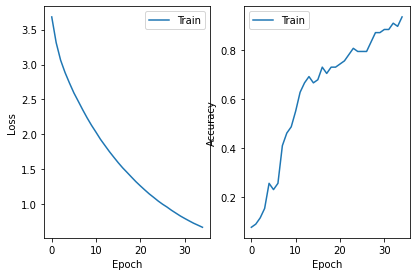

In [21]:
# Plot the training/validation history of our Keras model
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plot_metrics(history)
#warnings.filterwarnings("ignore")

- The above charts above show the loss getting lower and the accuracy getting better per epoch. The accuracy increases less with a flatter slope around epoch 30, indicated the right number of epochs.

Performance Evaluation

In [22]:
def plot_cm(labels, predictions):
  cm = confusion_matrix(labels, predictions)
  plt.figure(figsize=(8,8))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion Matrix')
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

Make output predictions using test data

In [23]:
#Predictions
y_test_predictions = (model.predict(input_test_array, batch_size = 26) > 0.5).astype("int32")
#y_test_predictions

Compare predicted test output against actual

In [24]:
#Create Confusion matrix
#y_test_predictions = model.predict_classes(input_test_array, batch_size=26)
y_test_predictions = (model.predict(input_test_array, batch_size = 26) > 0.5).astype("int32")
baseline_results = model.evaluate(input_test_array, output_test_array,
                                  batch_size=26, verbose=0)

for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

#plot_cm(output_test_array, y_test_predictions)

loss :  0.6436604261398315
accuracy :  0.9358974099159241



- The model performs well on the test data well, with 84% accuracy.

In [25]:
#save final model to reload in the future
model.save('dnn_model_CharRecognition')

INFO:tensorflow:Assets written to: dnn_model_CharRecognition\assets
